<font size="4" face="verdana" color="red"> Brainery Byte
<hr></font>
<font size="6" face="verdana" color="blue">Sections in OpenSees: <br>
    <b>MOMENT-CURVATURE & P-M INTERACTION </b><br>
    <br>
<br>
Circular Reinforced Concrete Section
</font><p>

<font size="4" face="verdana" color="black">
 R210706 <br>
 Silvia Mazzoni, 2021 <br>
      silviamazzoni@yahoo.com <br>

<br>
NOTES:
    <ol>
        <li> TENSION IS POSITIVE, COMPRESSION IS NEGATIVE, throughout!
        <li> This script takes advantage of dictionaries as a data structure to store model info. Using this apparent extra step allows you to store the information of your model in case you need to use it in post-processing. For example, it allows you to draw the fiber sections</li>
 <li>While this implementation uses a Standard AISC W section and RC Sections as examples, you can replace the section-defining module with your own section definition.</li>
        <li>Yes this WebApp uses function eSEESminiPy package to make the tool easier to use</li>
    </ol>
</font>
    
<BR>
<font size="4" face="verdana" color="black">
    <b>Process Outline:</b>
<ol type="1">
  <li>Initialize Pyton -- add necessary libraries and notebook setup</li>
  <li>Initialize javascript
  <li>Define Units (optional, but handy)</li>
  <li>Initialize Arrays Variables</li>
  <li>Define python utilities: define functions that make programming easier</li>
  <li>Define Normalized Loading Cycles for Material and Section Testing</li>
  <li>Start up OpenSees</li>
    <br>

  <li>For each Fiber section:</li>
    <ol type = "a">
      <li>Define Fiber Section (P-M-M interaction + Torsion)</li>
          <ol>
          <li>Initialize Section data and arrays</li>
          <li>Define Materials</li>
          <li>Test Materials</li>
          <li>Define Fiber geometry and material</li>
          <ol>
              <li>Define physical material fibers via patches, layers and fibers</li>
              <li>Define zero-area fibers for recorders</li>
          </ol>
          <li>Draw fiber section for visualization</li>
          <li>Define fiber Section in OpenSees</li>
        </ol>
      <li>Define Aggregated Section </li>
        <ol> 
            <li>define Vx and Vy behaviors </li>
            <li>aggregate Vx and Vy to Fiber Section in OpenSees using the '-section' option</li>
        </ol>
    </ol>
    <br>
          <li> For each Loading directin (z,y):</li>
          <ol>
              <li>Test Moment-Curvature response of Fiber Section at an axial load</li>
              <li> P-M interaction Analysis: Moment-Curvature response at a series of axial loads
          </ol>
</ol>
</font>
    
When you are done, you can print the notebook. You can also download the notebook to your local computer.

Because we are working in Binder, and Binder sessions are meant to be ephemeral, it is not possible for you to save any changes you make to your Jupyter Notebook. If you do make changes or notes, you will need to download the notebook to your own computer by clicking File > Download as > Notebook (.ipynb). The only way you will be able to run these is if you have the appropriate software to run Jupyter Notebooks in Python and pip install OpenSeesPy and eSEESminiPy in your Python configuration. You may view my videos on how to install Anaconda, Jupyter Notebooks and OpenSeesPy (https://www.youtube.com/c/silviasbrainery).
    
This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable

In [1]:
# Initalize Python Libraries
import openseespy.opensees as ops
import eSEESminiPy
import matplotlib.pyplot as plt
import math

In [2]:
%%javascript
// expand output box so graphs are viewed in notebook properly
IPython.OutputArea.auto_scroll_threshold = 1000;

<IPython.core.display.Javascript object>

In [3]:
# define UNITS ----------------------------------------------------------------------------
inch  = 1.  # define basic units -- output units
kip  = 1. # define basic units -- output units
sec  = 1. # define basic units -- output units
LunitTXT  = 'inch' # define basic-unit text for output
FunitTXT  = 'kip' # define basic-unit text for output
TunitTXT  = 'sec' # define basic-unit text for output
ft  = 12.*inch # define engineering units
ksi  = kip/math.pow(inch,2)
psi  = ksi/1000.
lbf  = psi*inch*inch # pounds force
pcf  = lbf/math.pow(ft,3) # pounds per cubic foot
psf  = lbf/math.pow(ft,3) # pounds per square foot
inch2  = inch*inch # inch^2
inch4  = inch*inch*inch*inch # inch^4
cm  = inch/2.54 # centimeter, needed for displacement input in MultipleSupport excitation
PI  = 2*math.asin(1.0) # define constants
g  = 32.2*ft/math.pow(sec,2) # gravitational acceleration
Ubig  = 1.e10 # a really large number
Usmall  = 1/Ubig # a really small number
inchInv = 1/inch;


In [4]:
# Initialize Arrays and variables
global matTag
matTag = 0
secTag = 0
SectionTagMap = {}
MaterialTagMap = {}
allSectionData = {}
WsectionData = {}
MomCurvData = {}
MatStressStrainData = {}
SectionLabelList = []
plt.close('all')
# Define bending directions for moment-curvature analysis
# you may remove either y or z if needed.
BendingDirectionList = ['z','y']

In [5]:
# UTILITIES
# Define some local handy procs
def addMaterial(MaterialType,InputArray):
    global matTag
    matTag += 1
    ops.uniaxialMaterial(MaterialType,matTag,*InputArray)
    return matTag

### Plot Moment-Curvature Responses
def plotMomCurv(testSectionLabel,MomCurvData):
    thisFig = {}
    axModel = {}
    thisFigMomCurv = plt.figure('Moment Curvature ' + testSectionLabel,figsize=(6,3), dpi=200, facecolor='w', edgecolor='k' )
    iAx = 0
    for BendingDirection in MomCurvData[testSectionLabel].keys():
        iAx += 1
        axMomCurv = thisFigMomCurv.add_subplot(1,len(MomCurvData[testSectionLabel].keys()),iAx)
        line, = axMomCurv.plot(MomCurvData[testSectionLabel][BendingDirection]['Curvature'], MomCurvData[testSectionLabel][BendingDirection]['Moment'])
        eSEESminiPy.formatAx(axMomCurv,'Moment-Curvature ' + testSectionLabel+ ' ' + BendingDirection,'Curvature ' + BendingDirection,'Moment ' + BendingDirection,6,6)
        for thisFiberLabel in MomCurvData[testSectionLabel][BendingDirection]['StrainData'][SectionTagMap[testSectionLabel]].keys():
            if iAx == 1:
                thisFig[thisFiberLabel] = plt.figure('Stress Strain ' + thisFiberLabel,figsize=(4,1), dpi=200, facecolor='w', edgecolor='k' )
            axModel[thisFiberLabel] = thisFig[thisFiberLabel].add_subplot(1,len(MomCurvData[testSectionLabel].keys()),iAx)
            line, = axModel[thisFiberLabel].plot(MomCurvData[testSectionLabel][BendingDirection]['StrainData'][SectionTagMap[testSectionLabel]][thisFiberLabel],MomCurvData[testSectionLabel][BendingDirection]['StressData'][SectionTagMap[testSectionLabel]][thisFiberLabel], 'k',linewidth = 1)
            eSEESminiPy.formatAx(axModel[thisFiberLabel],'Stress Strain ' + thisFiberLabel + " " + BendingDirection,'Strain ' + BendingDirection,'Stress ' + BendingDirection,6,6)
            
# Plot P-M Interaction Data
def plotPMInterax(testSectionLabel,PMinteraxData):
    FiberFig = {}
    FiberAx = {}
    thisFigPMI = plt.figure('P-M Interax ' + testSectionLabel,figsize=(6,3), dpi=200, facecolor='w', edgecolor='k' )
    thisFigMomCurv = plt.figure('Moment Curvature ' + testSectionLabel,figsize=(6,3), dpi=200, facecolor='w', edgecolor='k' )
    iAx = 0
    for BendingDirection in BendingDirectionList:
        iAx += 1
        axPMI = thisFigPMI.add_subplot(1,2,iAx)
        axMomCurv = thisFigMomCurv.add_subplot(1,2,iAx)

        for CurvatureSign in PMinteraxData[testSectionLabel][BendingDirection].keys():
            for thisAxial in  PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign].keys():
                thisMomCurvData = PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign][thisAxial]
                line, = axPMI.plot(thisMomCurvData['Moment'], thisMomCurvData['AxialForce'])
                axPMI.plot(max(thisMomCurvData['Moment'], key=abs), thisAxial,'ro',markerSize = 2,linewidth = 1)
                line, = axMomCurv.plot(thisMomCurvData['Curvature'], thisMomCurvData['Moment'])
                StrainData = thisMomCurvData['StrainData'][SectionTagMap[testSectionLabel]]
                StressData = thisMomCurvData['StressData'][SectionTagMap[testSectionLabel]]
                for thisFiberLabel,thisFiberStrain in StrainData.items():
                    if not thisFiberLabel in FiberFig.keys():
                        FiberFig[thisFiberLabel]= plt.figure('Fiber SS ' + testSectionLabel + thisFiberLabel,figsize=(4,1), dpi=200, facecolor='w', edgecolor='k' )
                    if not thisFiberLabel+ ' ' + BendingDirection in FiberAx.keys():
                        FiberAx[thisFiberLabel+ ' ' + BendingDirection] = FiberFig[thisFiberLabel].add_subplot(1,2,iAx)
                    thisFiberStress = StressData[thisFiberLabel]
                    line, = FiberAx[thisFiberLabel+ ' ' + BendingDirection].plot(thisFiberStrain,thisFiberStress,linewidth = 1)
        eSEESminiPy.formatAx(axPMI,'P-M Interax ' + testSectionLabel + ' ' + BendingDirection,'Bending Moment ' + BendingDirection,'Axial Force',6,6)
        eSEESminiPy.formatAx(axMomCurv,'P-M Interax MomentCurv ' + testSectionLabel + ' ' + BendingDirection ,'Curvature ' + BendingDirection,'Bending Moment ' + BendingDirection,6,6)
        eSEESminiPy.reverseYaxis(axPMI) # plot Axial Force Compression up
    for thisAxLabel,thisValue in FiberAx.items():
        eSEESminiPy.formatAx(thisValue,thisAxLabel,'Strain','Stress',6,6)


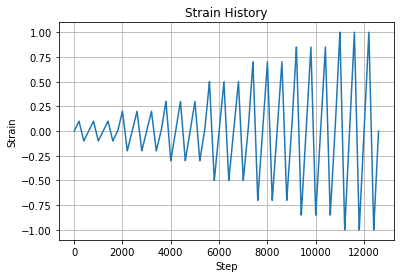

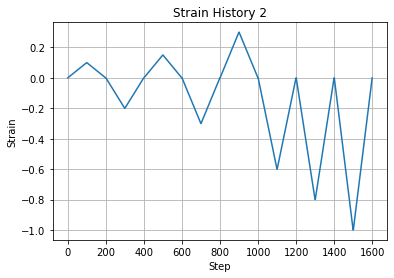

In [6]:
# Define Normalized Loading Cycles for Material and Section Testing.

# These cycles are normalized to have a maximum value of 1.0
# You can later change the amplitude factor depending on the application
peaksArray = [0.1,0.2,0.3,0.5,0.7,0.85,1.0]
nCycles = 3
nSteps = 200
StrainSeries = eSEESminiPy.defineStrainHistory(peaksArray,nCycles,nSteps)
eSEESminiPy.plotYoneList(StrainSeries,title='Strain History',Ylabel='Strain')

# for concrete you want more loading in compression for testing
peaksArray2 = [0.1,0,-0.2,0,0.15,0,-0.3,0,0.3,0,-0.6,0,-0.8,0,-1.0,0.0]
nCycles2 = 0; # do a single segment from one value to the next
nSteps = 100
StrainSeries2 = eSEESminiPy.defineStrainHistory(peaksArray2,nCycles2,nSteps)
eSEESminiPy.plotYoneList(StrainSeries2,title='Strain History 2',Ylabel='Strain')


In [7]:
# Start-up OpenSees
ops.wipe()
Dim = '3D'
ops.model('basic','-ndm',3,'-ndf',6)

############################################################################################################<p>
<font size="6" face="verdana" color="blue">Fiber Section, Circular RC Section <br></font>
############################################################################################################

In [8]:
################################################################################################
### REINFORCED-CONCRETE SECTION -- Circular
################################################################################################
MainSectionLabel = 'RCsectionCirc'

thisSectionType = '_FiberOnly'
thisSectionLabel = MainSectionLabel + thisSectionType

# initialize Section Data
thisSectionData = {}
thisMaterialTagMap = {}

## MATERIALS
# ##### Reinforcing steel:
# Define Steel Material
Fy=60*ksi
YoungsModulus = 2.900E+04*ksi
Bsh = 0.01

# Backbone points for Hysteretic Material
f1 = Fy
eps1 = Fy/YoungsModulus
eps2 = 20*eps1
f2 = f1+Bsh*(eps2-eps1)*(YoungsModulus)
f3 = 0.9*f2
eps3 = 50*eps1
PositiveEnvelopeData = [f1,eps1,f2,eps2,f3,eps3]
NegativeEnvelopeData = [-f1,-eps1,-f2,-eps2,-f3,-eps3]

# hyteretic-material properties
[pinchX,pinchY] = [1,1]
[damage1,damage2] = [0.0,0.0]
beta = 0.5
hystereticData = [pinchX,pinchY,damage1,damage2,beta]
thisMaterialTagMap['Steel'] = addMaterial('Hysteretic',[*PositiveEnvelopeData,*NegativeEnvelopeData,*hystereticData])

# ##### Concrete:
# nominal concrete compressive strength
fc  = -4.0*ksi # CONCRETE Compressive Strength, ksi (+Tension, -Compression)
Ec  = 57*ksi*math.sqrt(-fc/psi) # Concrete Elastic Modulus
nu  = 0.2
ShearModulus  = Ec/2./(1+nu) # Torsional stiffness Modulus

# confined concrete
Kfc  = 1.3 # ratio of confined to unconfined concrete strength
Kres  = 0.2 # ratio of residual/ultimate to maximum stress
fc1C  = Kfc*fc # CONFINED concrete (mander model), maximum stress
eps1C  = 2.*fc1C/Ec # strain at maximum stress
fc2C  = Kres*fc1C # ultimate stress
eps2C  = 20*eps1C # strain at ultimate stress
Lambda  = 0.1 # ratio between unloading slope at eps2 and initial slope Ec
# unconfined concrete
fc1U  = fc # UNCONFINED concrete (todeschini parabolic model), maximum stress
eps1U  = -0.003 # strain at maximum strength of unconfined concrete
fc2U  = Kres*fc1U # ultimate stress
eps2U  = -0.01 # strain at ultimate stress

# tensile-strength properties
ftC  = -0.14*fc1C # tensile strength+tension
ftU  = -0.14*fc1U # tensile strength+tension
Ets  = ftU/0.002 # tension softening stiffness

# Define Materials:
thisMaterialTagMap['UnconfinedConcrete'] = addMaterial('Concrete02',[fc1U,eps1U,fc2U,eps2U,Lambda,ftU,Ets])
thisMaterialTagMap['ConfinedConcrete'] = addMaterial('Concrete02',[fc1C,eps1C,fc2C,eps2C,Lambda,ftC,Ets])
thisMaterialTagMap['ConfinedConcrete2'] = addMaterial('Concrete02',[1.05*fc1C,eps1C,1.05*fc2C,eps2C,Lambda,ftC,Ets])

# Add material maps to all
MaterialTagMap[thisSectionLabel] = thisMaterialTagMap


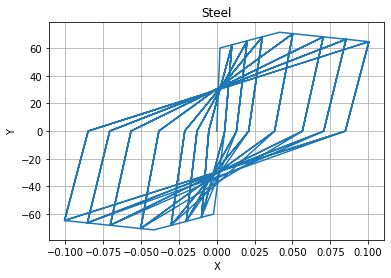

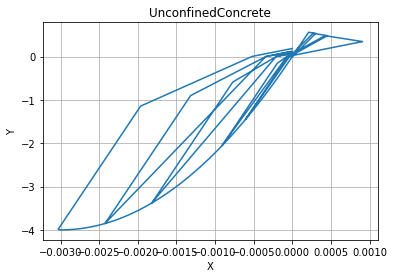

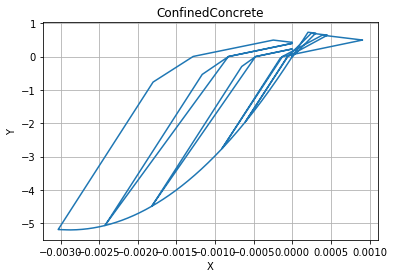

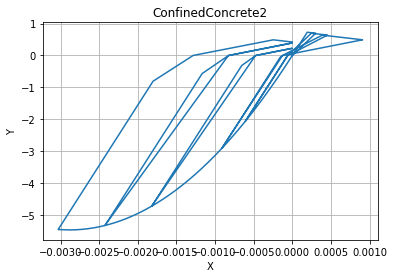

In [9]:
# Test Materials
thisMatStressStrainData = {}
# you may have some convergence problems here because I can't add a stabilizing elastic element in the procedure.
# use symmetric loading for Steel
ampFactor = 0.1
thisMatStressStrainData['Steel'] = eSEESminiPy.getMaterialStressStrain(Dim,thisMaterialTagMap['Steel'],StrainSeries,ampFactor)
# use more-compression loading for concrete
ampFactor = 0.003
thisMatStressStrainData['UnconfinedConcrete'] = eSEESminiPy.getMaterialStressStrain(Dim,thisMaterialTagMap['UnconfinedConcrete'],StrainSeries2,ampFactor)
thisMatStressStrainData['ConfinedConcrete'] = eSEESminiPy.getMaterialStressStrain(Dim,thisMaterialTagMap['ConfinedConcrete'],StrainSeries2,ampFactor)
thisMatStressStrainData['ConfinedConcrete2'] = eSEESminiPy.getMaterialStressStrain(Dim,thisMaterialTagMap['ConfinedConcrete2'],StrainSeries2,ampFactor)

for thisMaterialLabel in thisMatStressStrainData.keys():
    eSEESminiPy.plotXYoneList(thisMatStressStrainData[thisMaterialLabel]['strain'],thisMatStressStrainData[thisMaterialLabel]['stress'],thisMaterialLabel)

# Add material response to all
MatStressStrainData[thisSectionLabel] = thisMatStressStrainData

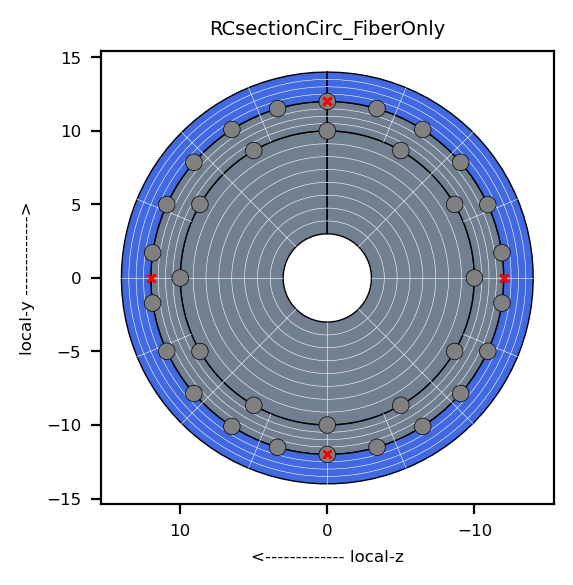

In [10]:
# FIBER SECTION properties
# assign a section Tag for OpenSees and save it in the data map
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag

# Column section geometry:
DCol  = 28*inch
DColInner = 6*inch
thisSectionData['Ag'] = math.pi*DCol*DCol/4 - math.pi*DColInner*DColInner/4

cover  = 2*inch 
layerspacing = 2.0*inch

numBarsOuter  = 22 # number of longitudinal-reinforcement bars
numBarsInner  = 12 
barAreaOuter  = 1.*inch*inch # longitudinal-reinforcement bar area
barAreaInner  = 1.*inch*inch 

# axial strength of column, Compression and tension
thisSectionData['PmaxC'] = thisSectionData['Ag']*fc - (numBarsOuter*barAreaOuter + numBarsInner*barAreaInner)*Fy
thisSectionData['PmaxT'] = 0.99*(numBarsOuter*barAreaOuter + numBarsInner*barAreaInner)*Fy


nfCoreR  = 8 # number of radial divisions in the core (number of "rings")
nfCoreT  = 8 # number of theta divisions in the core (number of "wedges")
nfCoreMidR  = 4 # number of radial divisions in the cover
nfCoreMidT  = 16 # number of theta divisions in the cover
nfCoverR  = 4 # number of radial divisions in the cover
nfCoverT  = 16 # number of theta divisions in the cover

# Torsional Stiffness
GJ = 1e9
thisSectionData['GJ'] = GJ

[coreID,coverID,steelID] = [thisMaterialTagMap['ConfinedConcrete'],thisMaterialTagMap['UnconfinedConcrete'],thisMaterialTagMap['Steel']]

Rinner = DColInner/2
Router = DCol/2
Rcore = Router - cover
Rcore2 = Router - cover - layerspacing

# Define the fiber section
FiberSectionCommandData = {}
FiberSectionCommandData['sectionCall'] = ['section','Fiber',secTag,'-GJ',GJ]
# Define the core patch
FiberSectionCommandData['CorePatch'] = ['patch','circ',coreID,nfCoreT,nfCoreR,0,0,Rinner,Rcore2,0,360]
# Define the cover patch
FiberSectionCommandData['MidPatch'] = ['patch','circ',coreID,nfCoreMidT,nfCoreMidR,0,0,Rcore2,Rcore,0,360]
FiberSectionCommandData['CoverPatch'] = ['patch','circ',coverID,nfCoverT,nfCoverR,0,0,Rcore,Router,0,360]
# Define reinforcing layers
thetaOuter  = 360.0/numBarsOuter # Determine angle increment between bars for the start of the layer, otherwise you'd be double counting
thetaInner  = 360.0/numBarsInner # Determine angle increment between bars for the start of the layer, otherwise you'd be double counting
FiberSectionCommandData['OuterReinf'] = ['layer','circ',steelID,numBarsOuter,barAreaOuter,0,0,Rcore,0,360-thetaOuter]
FiberSectionCommandData['InnerReinf'] = ['layer','circ',steelID,numBarsInner,barAreaInner,0,0,Rcore2,0,360-thetaInner]


# Add recorder fibers (zero area) and define strain limit states
strainLimitsSteel = {}
strainLimitsSteel['SteelYield'] = [-1.1*Fy/YoungsModulus,1.1*Fy/YoungsModulus]
strainLimitsSteel['LS'] = [-4*Fy/YoungsModulus,4*Fy/YoungsModulus]
strainLimitsSteel['CP'] = [-8*Fy/YoungsModulus,8*Fy/YoungsModulus]
strainLimitsConcrete = {}
strainLimitsConcrete['LS'] = [-2*0.004,999]
strainLimitsConcrete['CP'] = [-4*0.004,999]
strainLimitsConcrete['ConcreteCrushing'] = [-0.004,999]

FiberSectionCommandData['BottomSteel'] = ['fiber',-Rcore,0,0,steelID,strainLimitsSteel]
FiberSectionCommandData['TopSteel'] = ['fiber',Rcore,0,0,steelID,strainLimitsSteel]
FiberSectionCommandData['RightSteel'] = ['fiber',0,Rcore,0,steelID,strainLimitsSteel]
FiberSectionCommandData['LeftSteel'] = ['fiber',0,-Rcore,0,steelID,strainLimitsSteel]
FiberSectionCommandData['BottomCore'] = ['fiber',-Rcore,0,0,coreID,strainLimitsConcrete]
FiberSectionCommandData['TopCore'] = ['fiber',Rcore,0,0,coreID,strainLimitsConcrete]
FiberSectionCommandData['RightCore'] = ['fiber',0,Rcore,0,coreID,strainLimitsConcrete]
FiberSectionCommandData['LeftCore'] = ['fiber',0,-Rcore,0,coreID,strainLimitsConcrete]
FiberSectionCommandData['Origin'] = ['fiber',Rcore,0,0,coreID]



# assign all these data to section
thisSectionData['FiberSectionCommandData'] = FiberSectionCommandData

# draw Fiber Section:
eSEESminiPy.drawFiberSection(FiberSectionCommandData,thisSectionLabel)

# buildSection:
ops.section(*FiberSectionCommandData['sectionCall'][1:])
for thisFiberLabel,thisFiberCommandData in FiberSectionCommandData.items():
    fiberType = thisFiberCommandData[0]
    if fiberType == 'patch':
        ops.patch(*thisFiberCommandData[1:12+1])
    elif fiberType == 'layer':
        if thisFiberCommandData[3]>0:
            ops.layer(*thisFiberCommandData[1:8+1])
    elif fiberType == 'fiber':
        ops.fiber(*thisFiberCommandData[1:4+1])

# add to all
allSectionData[thisSectionLabel] = thisSectionData


In [11]:
## RUN Moment-Curvature Analysis
testSectionLabel = MainSectionLabel + thisSectionType
MomCurvData[testSectionLabel] = {}

# The InputSection is a single argument to the Moment-Curvature Analysis
# If you want strain-recorder data, include the FiberSectionDommandData into a list:
FiberSectionCommandData = allSectionData[testSectionLabel]['FiberSectionCommandData']
InputSection = [SectionTagMap[testSectionLabel],FiberSectionCommandData]

### MOMENT-CURVATURE ANALYSIS
axialLoad = 180
ampFactor = 0.01
thisLimitState = '' # no limit state as we are doing a cyclic analysis
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel][BendingDirection] = eSEESminiPy.runMomentCurvature(InputSection,axialLoad,StrainSeries,5,Dim+BendingDirection,ampFactor,thisLimitState)
    

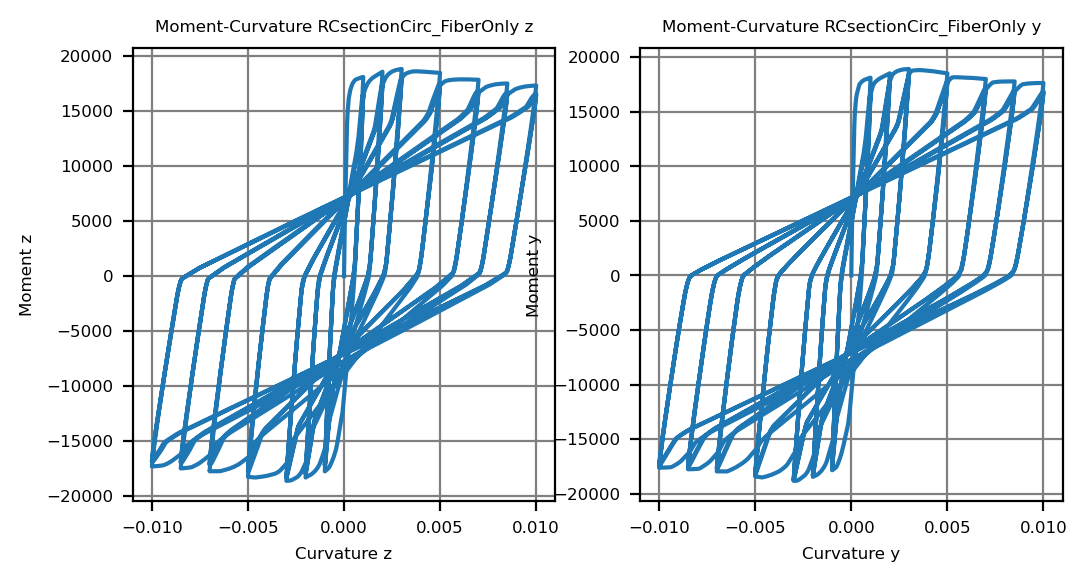

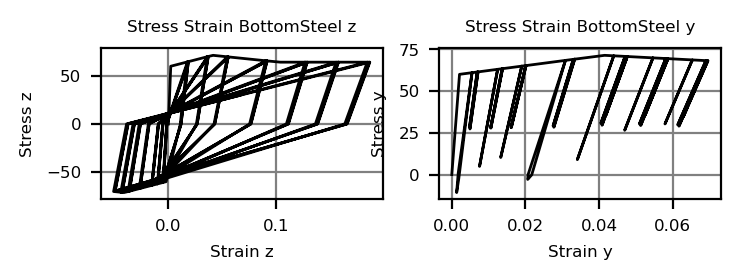

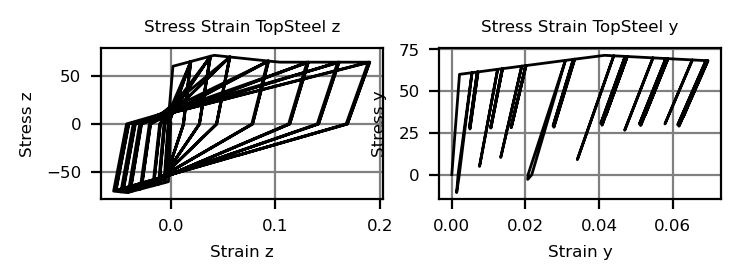

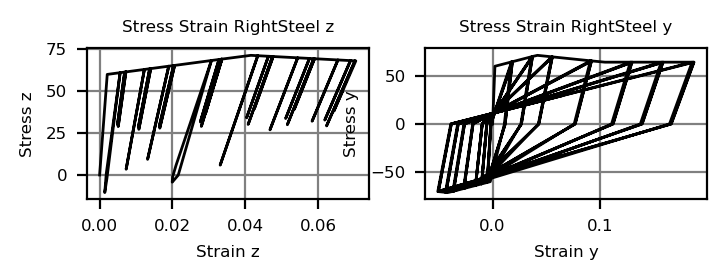

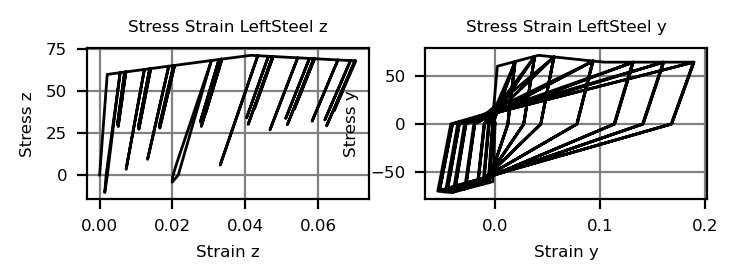

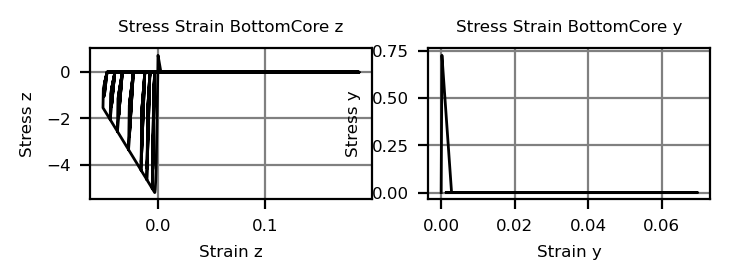

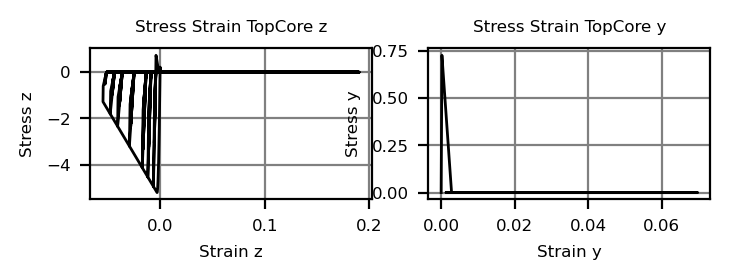

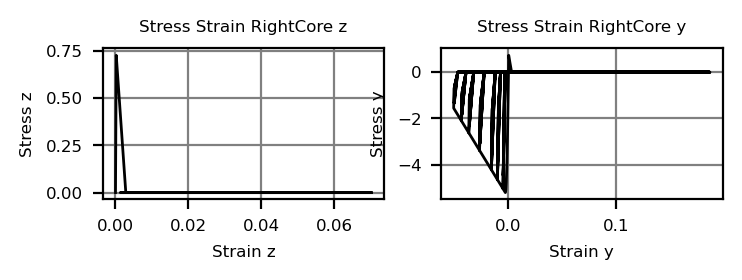

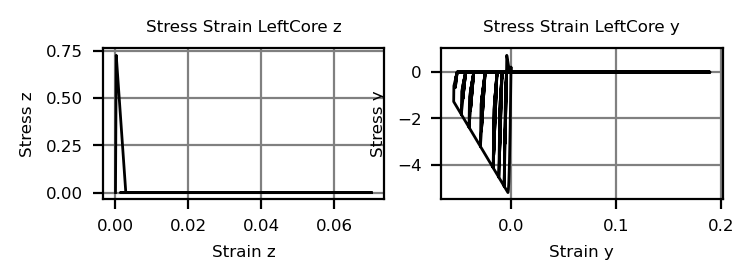

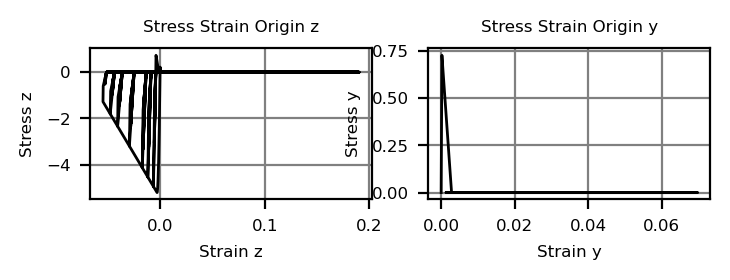

In [12]:
### Plot Moment-Curvature Responses
plotMomCurv(testSectionLabel,MomCurvData)

In [13]:
# RUN MOMENT CURVATURE TO LIMIT STATE
testSectionLabel = MainSectionLabel + thisSectionType


# The InputSection is a single argument to the Moment-Curvature Analysis
# If you want strain-recorder data, include the FiberSectionDommandData into a list:
FiberSectionCommandData = allSectionData[testSectionLabel]['FiberSectionCommandData']
InputSection = [SectionTagMap[testSectionLabel],FiberSectionCommandData]

### MOMENT-CURVATURE ANALYSIS
axialLoad = 180
maxCurv = 1.0;
ampFactor = 0.01
thisLimitState = 'LS' # assign a limit state
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel][BendingDirection] = eSEESminiPy.runMomentCurvature(InputSection,axialLoad,maxCurv,100,Dim+BendingDirection,ampFactor,thisLimitState)
    

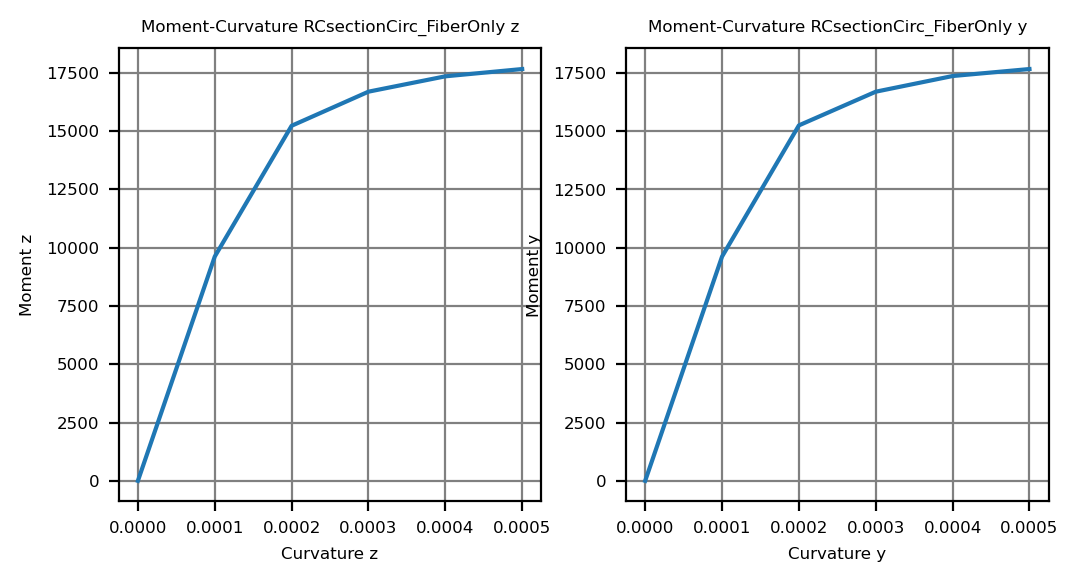

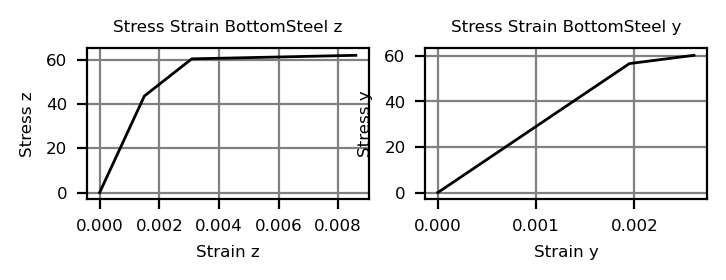

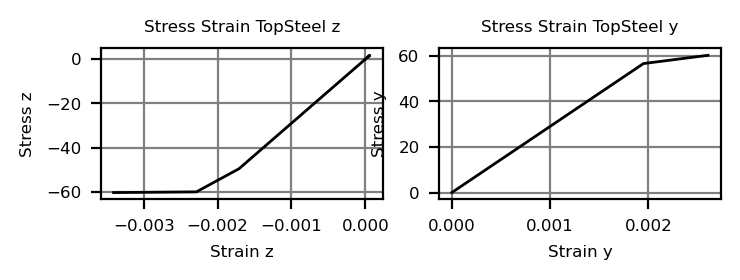

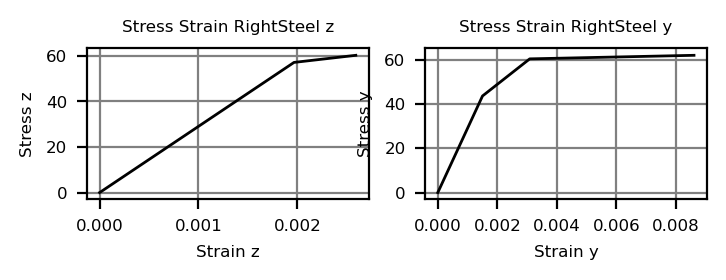

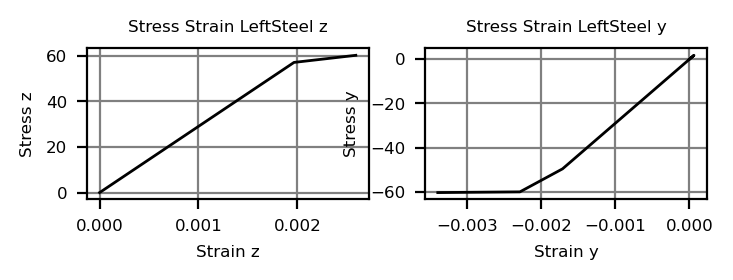

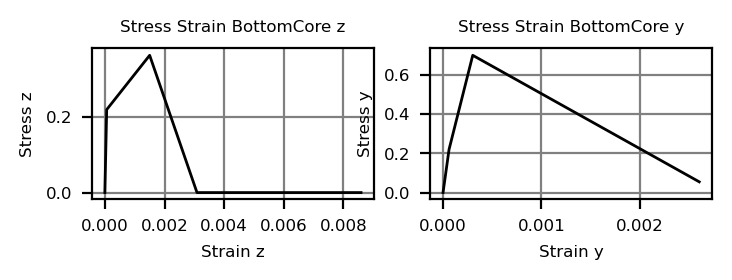

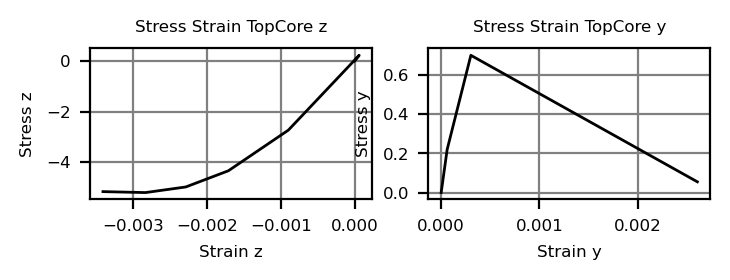

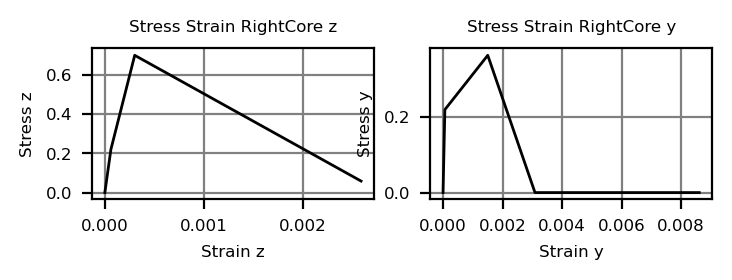

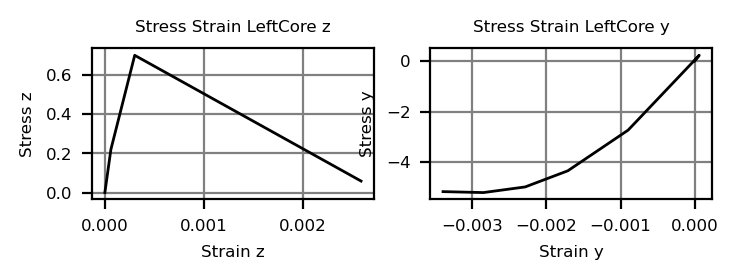

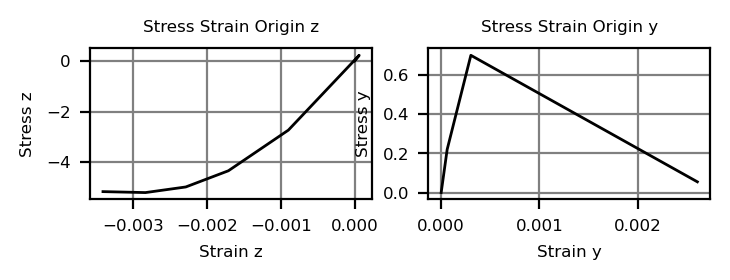

In [14]:
### Plot Moment-Curvature Responses
plotMomCurv(testSectionLabel,MomCurvData)

In [15]:
# perform P-M Interaction Analysis for limit state
testSectionLabel = MainSectionLabel + thisSectionType

KappaMax = 0.005
ampFactor = 1.0
thisLimitState = 'CP'

# Define Series of Axial Loads
PmaxC = allSectionData[testSectionLabel]['PmaxC']
PmaxT = allSectionData[testSectionLabel]['PmaxT']
NaxialPointsC = 20
NaxialPointsT = 10
PaxialList = []
for i in range(NaxialPointsC):
    PaxialList.append(PmaxC - i*PmaxC/NaxialPointsC)
for i in range(NaxialPointsT+1):
    PaxialList.append(i*PmaxT/NaxialPointsT)

PMinteraxData = {}
PMinteraxData[testSectionLabel] = {}
for BendingDirection in BendingDirectionList:
    PMinteraxData[testSectionLabel][BendingDirection] = {}
    for CurvatureSign in [+1,-1]:
        PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign] = {}
        for thisAxial in PaxialList:
            PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign][thisAxial] = eSEESminiPy.runMomentCurvature([SectionTagMap[testSectionLabel],FiberSectionCommandData],thisAxial,CurvatureSign*KappaMax,100,Dim+BendingDirection,ampFactor,thisLimitState)


after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > an

 current EnergyIncr: 7.51536e-07 (max: 1e-09) 	Norm deltaX: 6.93086e-07, Norm deltaR: 19.2324
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -526.865
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 7.51536e-07 (max: 1e-09) 	Norm deltaX: 6.93086e-07, Norm deltaR: 19.2324
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -526.865
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 7.51536e-07 (max: 1e-09) 	Norm deltaX: 6.93086e-07, Norm deltaR: 19.2324
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -526.865
OpenSees > analyze failed, returne

after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analy

after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analy

after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analy

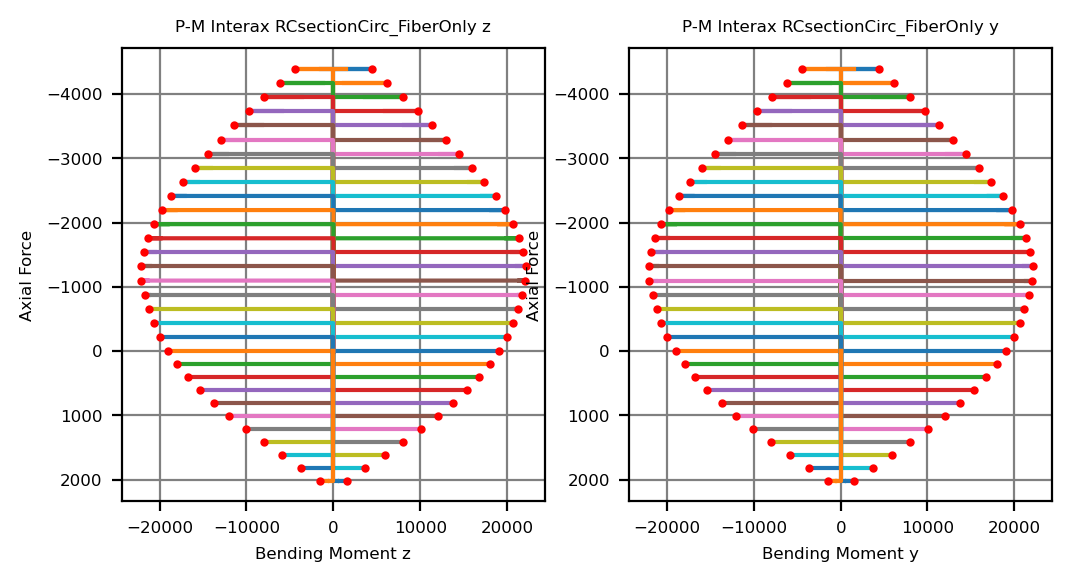

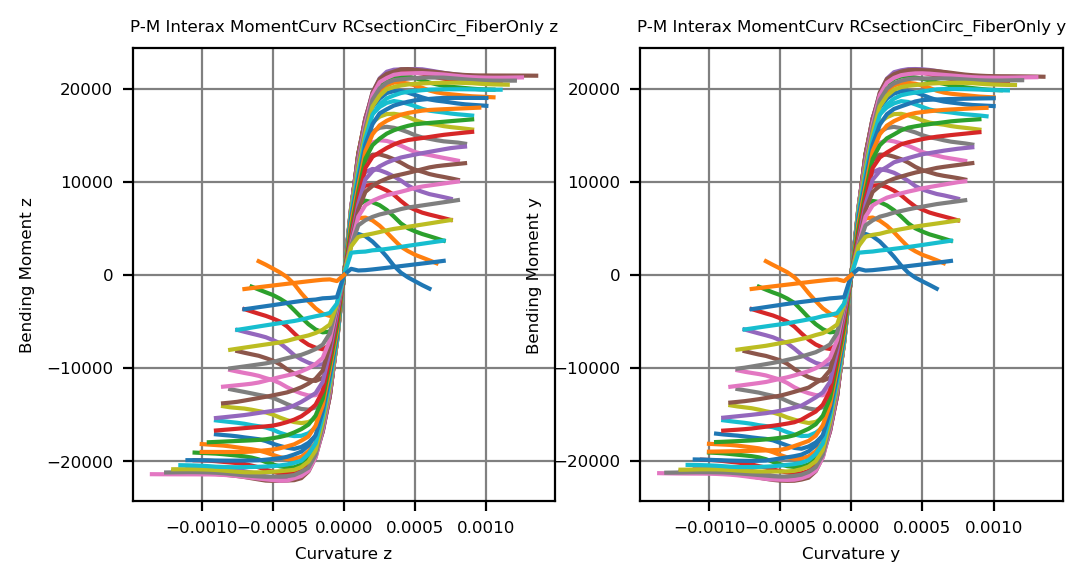

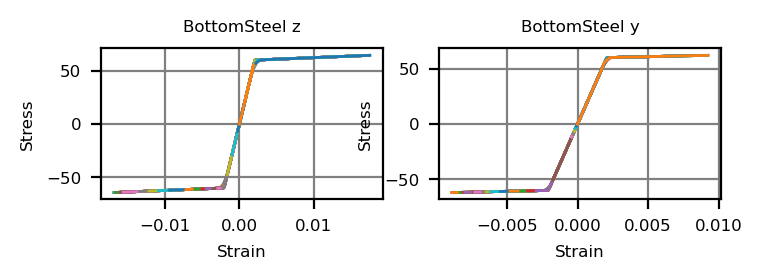

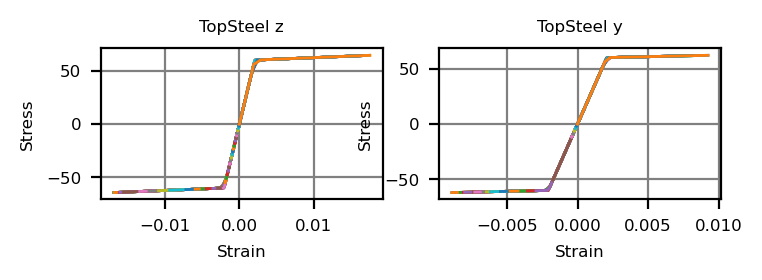

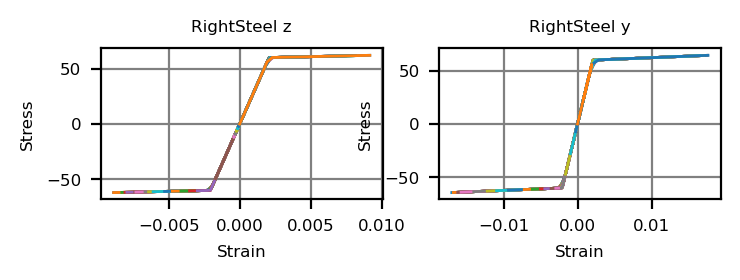

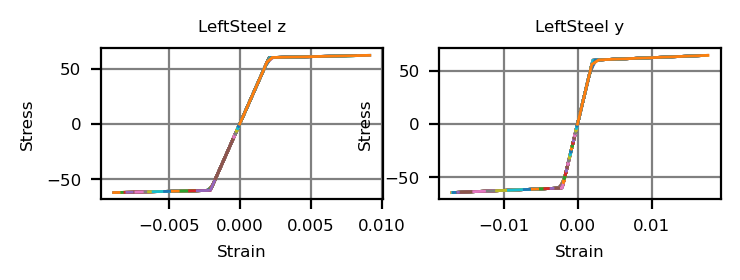

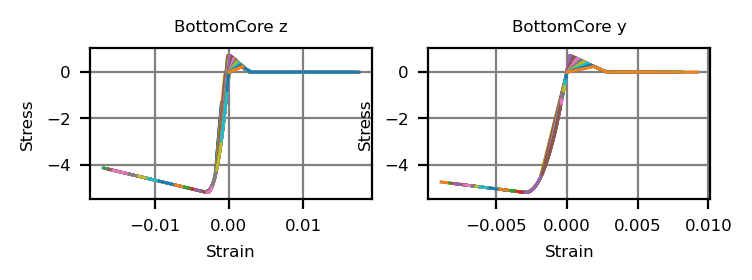

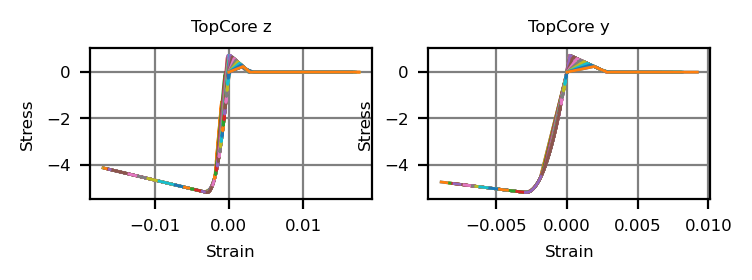

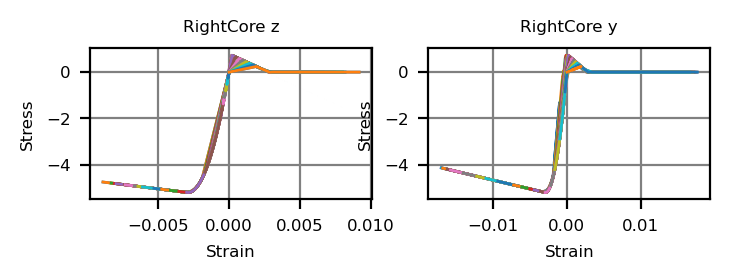

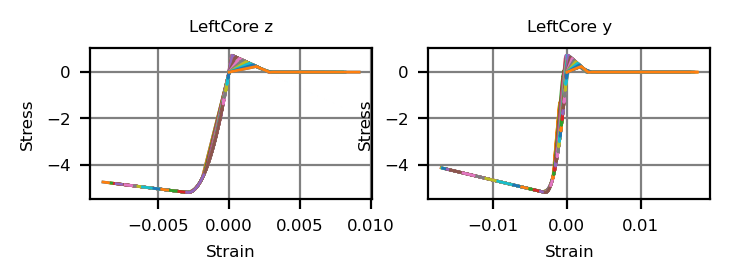

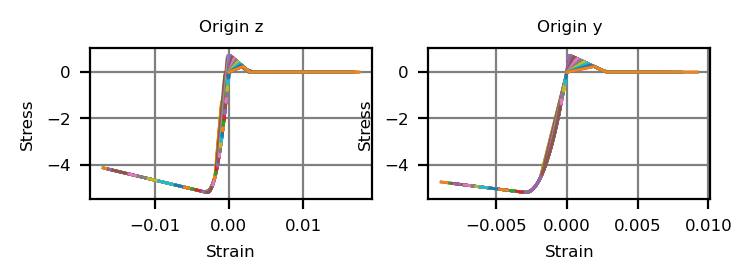

In [16]:
# Plot P-M Interaction Data
plotPMInterax(testSectionLabel,PMinteraxData)

############################################################################################################<p>
<font size="6" face="verdana" color="blue">Aggregated Fiber Section, Circular RC Section <br></font>
############################################################################################################

In [17]:
# 3D Aggregated Section for Fiber Section:
thisSectionType = '_3Daggregated'
thisSectionLabel = MainSectionLabel + thisSectionType

# Initialize
thisSectionData = allSectionData[MainSectionLabel + '_FiberOnly']
thisMaterialTagMap = {}
secTag += 1
SectionTagMap[thisSectionLabel] = secTag
thisSectionData['SectionTag'] = secTag

# Shear-Stiffness properties
ShearAreaY = thisSectionData['Ag']
ShearAreaZ = thisSectionData['Ag']

# Define uniaxialMaterials for uncoupled section behavior
MaterialTagMap[thisSectionLabel] = {}
thisMaterialTagMap['-section'] = SectionTagMap[MainSectionLabel + '_FiberOnly']
thisMaterialTagMap['Vy'] = addMaterial('Elastic',[ShearModulus*ShearAreaY])
thisMaterialTagMap['Vz'] = addMaterial('Elastic',[ShearModulus*ShearAreaZ])

# create input for Aggregator Section
SectionInputArray = []
for (thisLabel) in ['Vy','Vz']:
    SectionInputArray.append(thisMaterialTagMap[thisLabel])
    SectionInputArray.append(thisLabel)
SectionInputArray.extend(['-section',thisMaterialTagMap['-section']]) 
thisSectionData['SectionInputArray'] = SectionInputArray
print('OpenSees Input Data:' )
print(SectionInputArray)

ops.section('Aggregator', secTag, *SectionInputArray)

thisSectionData['SectionInputArray'] = SectionInputArray
# add to all
MaterialTagMap[thisSectionLabel] = thisMaterialTagMap
allSectionData[thisSectionLabel] = thisSectionData


OpenSees Input Data:
[5, 'Vy', 6, 'Vz', '-section', 1]


In [18]:
## RUN Moment-Curvature Analysis
testSectionLabel = MainSectionLabel + thisSectionType
MomCurvData[testSectionLabel] = {}

# The InputSection is a single argument to the Moment-Curvature Analysis
# If you want strain-recorder data, include the FiberSectionDommandData into a list:
FiberSectionCommandData = allSectionData[testSectionLabel]['FiberSectionCommandData']
InputSection = [SectionTagMap[testSectionLabel],FiberSectionCommandData]

### MOMENT-CURVATURE ANALYSIS
axialLoad = 180
ampFactor = 0.01
thisLimitState = '' # no limit state as we are doing a cyclic analysis
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel][BendingDirection] = eSEESminiPy.runMomentCurvature(InputSection,axialLoad,StrainSeries,5,Dim+BendingDirection,ampFactor,thisLimitState)
    

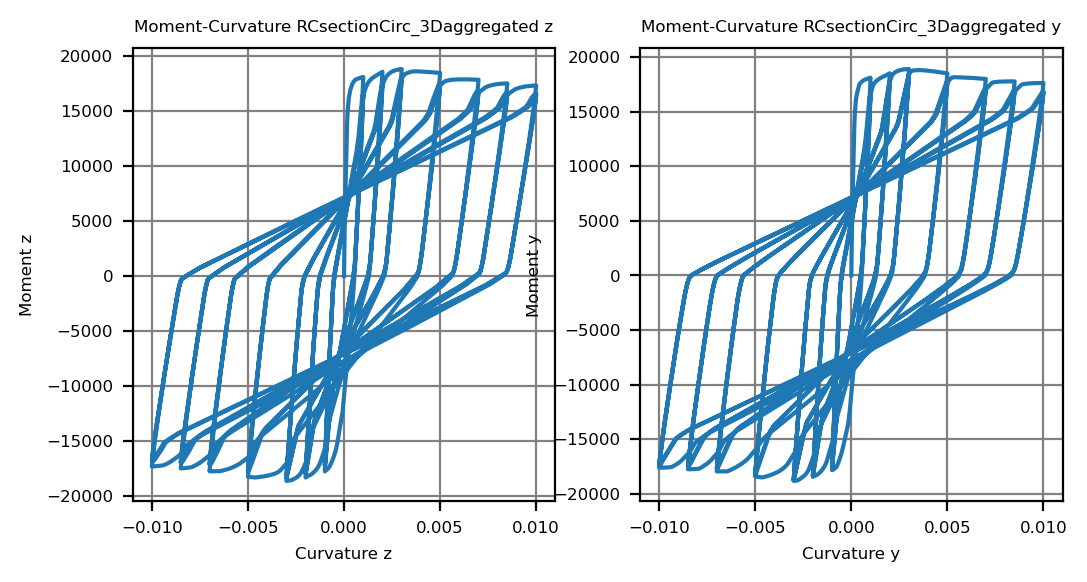

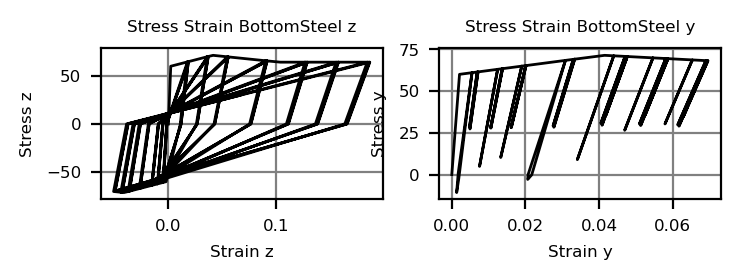

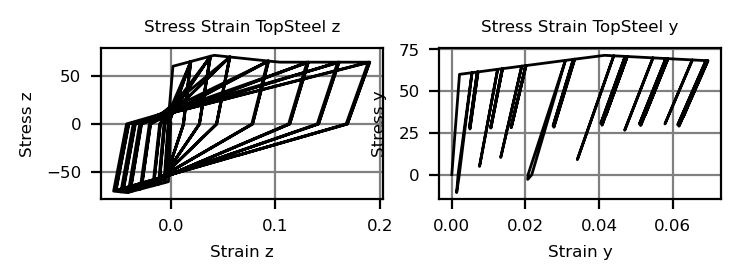

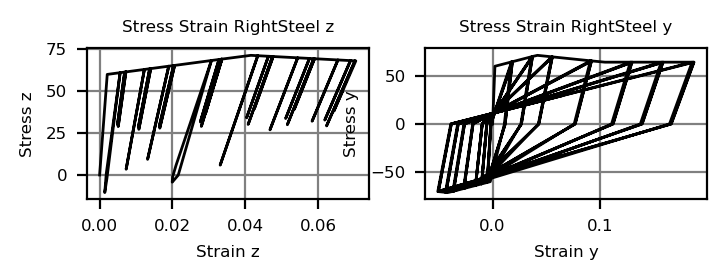

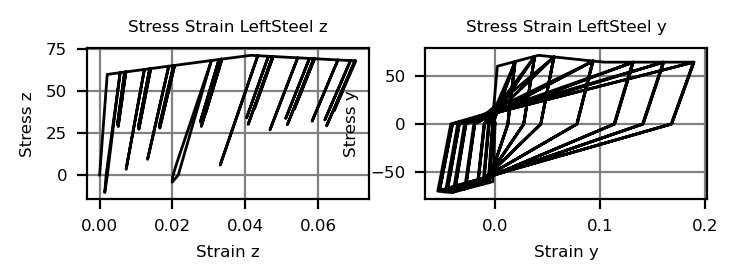

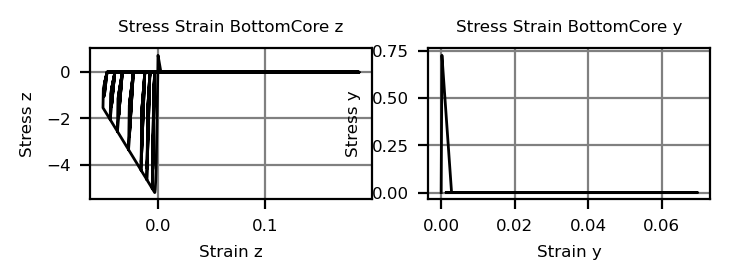

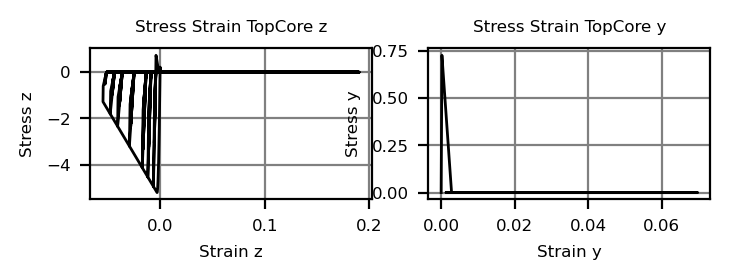

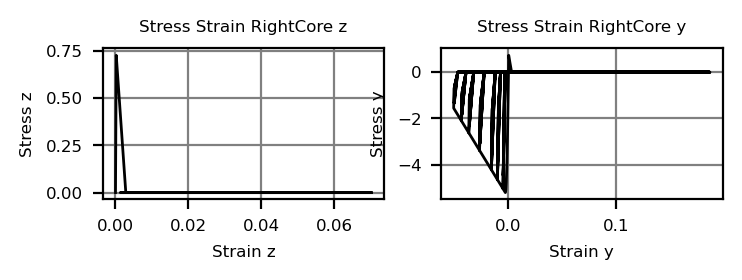

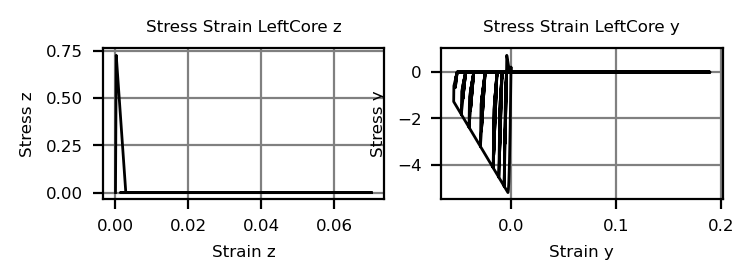

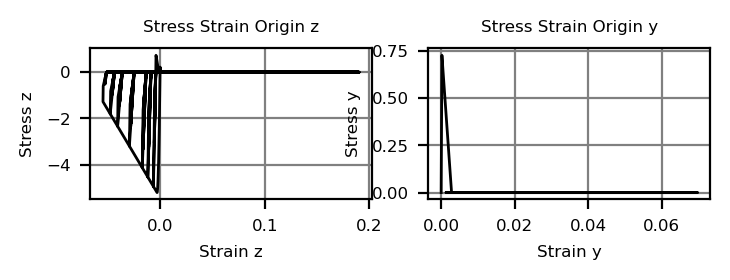

In [19]:
### Plot Moment-Curvature Responses
plotMomCurv(testSectionLabel,MomCurvData)

In [20]:
# RUN MOMENT CURVATURE TO LIMIT STATE
testSectionLabel = MainSectionLabel + thisSectionType

# The InputSection is a single argument to the Moment-Curvature Analysis
# If you want strain-recorder data, include the FiberSectionDommandData into a list:
FiberSectionCommandData = allSectionData[testSectionLabel]['FiberSectionCommandData']
InputSection = [SectionTagMap[testSectionLabel],FiberSectionCommandData]

### MOMENT-CURVATURE ANALYSIS
axialLoad = 180
maxCurv = 1.0;
ampFactor = 0.01
thisLimitState = 'LS' # assign a limit state
for BendingDirection in BendingDirectionList:
    MomCurvData[testSectionLabel][BendingDirection] = eSEESminiPy.runMomentCurvature(InputSection,axialLoad,maxCurv,100,Dim+BendingDirection,ampFactor,thisLimitState)
    

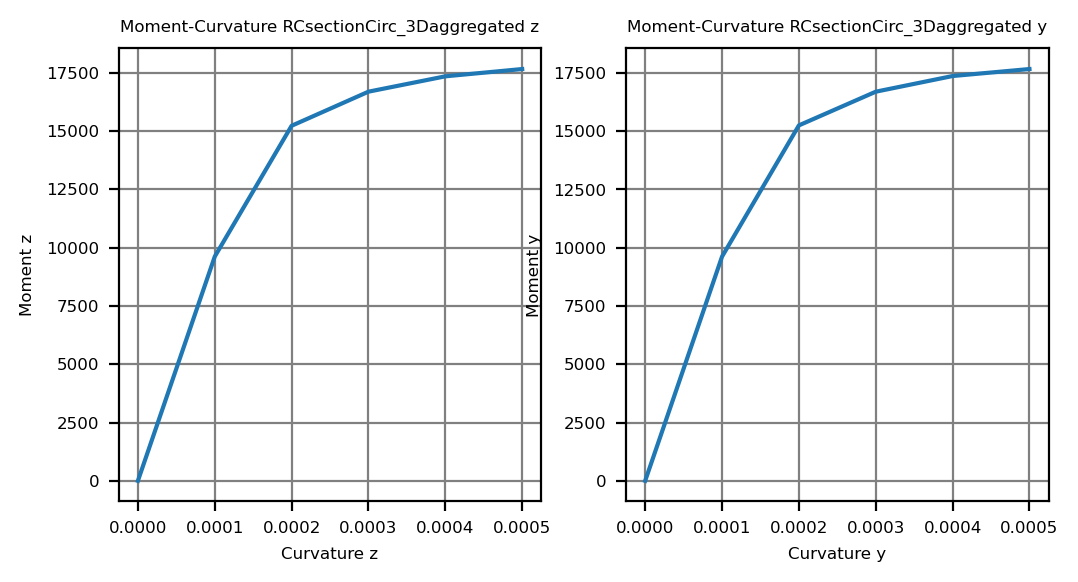

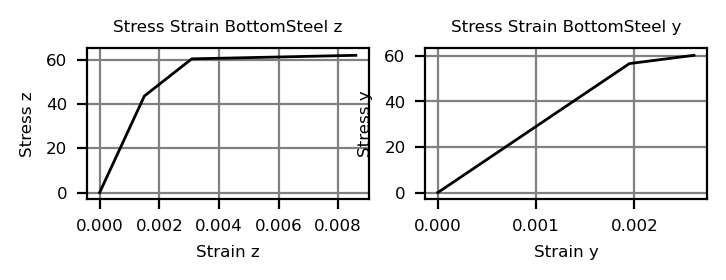

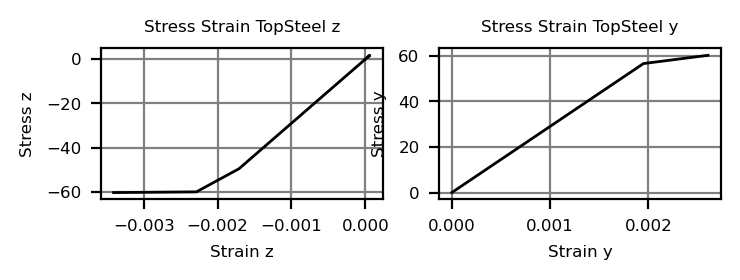

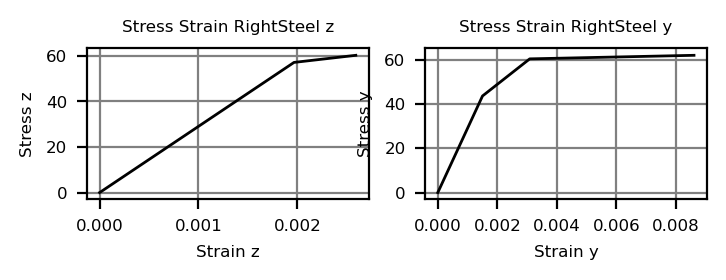

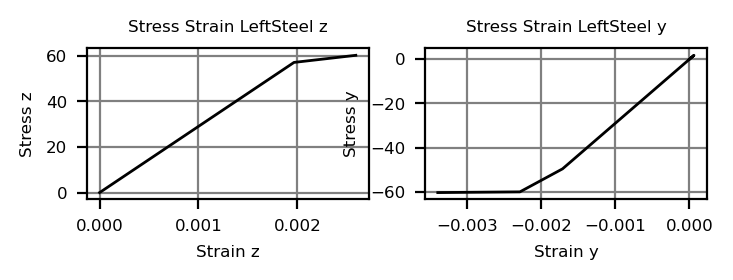

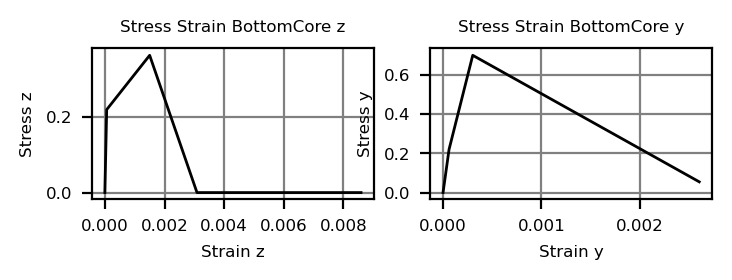

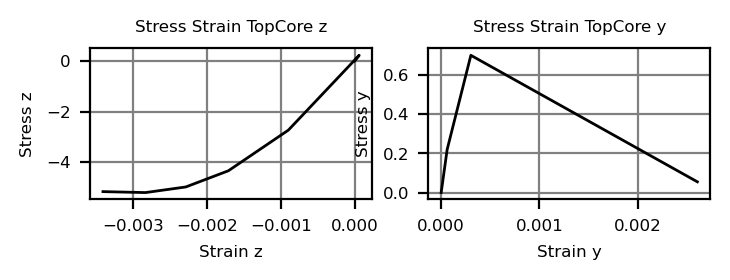

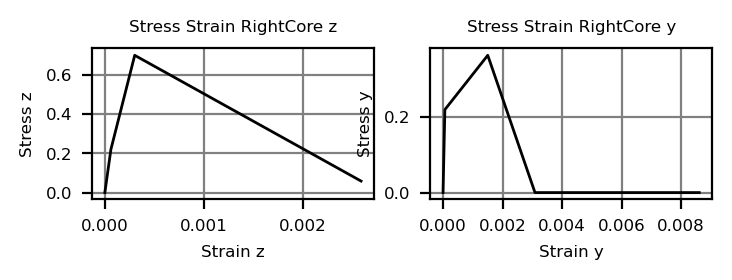

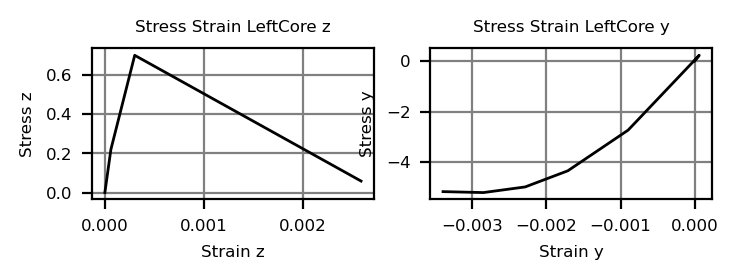

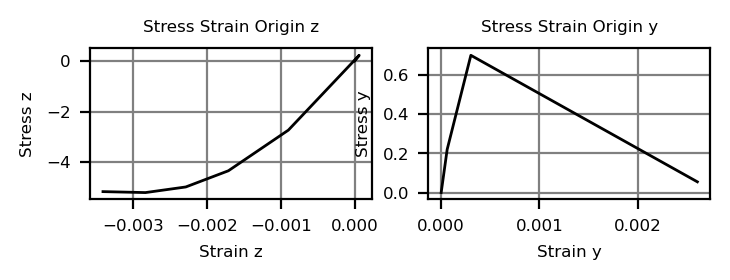

In [21]:
### Plot Moment-Curvature Responses
plotMomCurv(testSectionLabel,MomCurvData)

In [22]:
# perform P-M Interaction Analysis for limit state
testSectionLabel = MainSectionLabel + thisSectionType

KappaMax = 0.005
ampFactor = 1.0
thisLimitState = 'CP'

# Define Series of Axial Loads
PmaxC = allSectionData[testSectionLabel]['PmaxC']
PmaxT = allSectionData[testSectionLabel]['PmaxT']
NaxialPointsC = 20
NaxialPointsT = 10
PaxialList = []
for i in range(NaxialPointsC):
    PaxialList.append(PmaxC - i*PmaxC/NaxialPointsC)
for i in range(NaxialPointsT+1):
    PaxialList.append(i*PmaxT/NaxialPointsT)

PMinteraxData = {}
PMinteraxData[testSectionLabel] = {}
for BendingDirection in BendingDirectionList:
    PMinteraxData[testSectionLabel][BendingDirection] = {}
    for CurvatureSign in [+1,-1]:
        PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign] = {}
        for thisAxial in PaxialList:
            PMinteraxData[testSectionLabel][BendingDirection][CurvatureSign][thisAxial] = eSEESminiPy.runMomentCurvature([SectionTagMap[testSectionLabel],FiberSectionCommandData],thisAxial,CurvatureSign*KappaMax,100,Dim+BendingDirection,ampFactor,thisLimitState)


after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000302033 (max: 1e-09) 	Norm deltaX: 0.000103285, Norm deltaR: 68.7706
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1821.95
OpenSees > an

after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000301345 (max: 1e-09) 	Norm deltaX: 0.000103264, Norm deltaR: 68.3734
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1822.42
OpenSees > analy

after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000822352 (max: 1e-09) 	Norm deltaX: 0.00015658, Norm deltaR: 122.021
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor -1924.27
OpenSees > analy

after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 0.000833647 (max: 1e-09) 	Norm deltaX: 0.000156508, Norm deltaR: 124.017
NewtonRaphson::solveCurrentStep() -the ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at iteration: 0 with domain at load factor 1924.15
OpenSees > analy

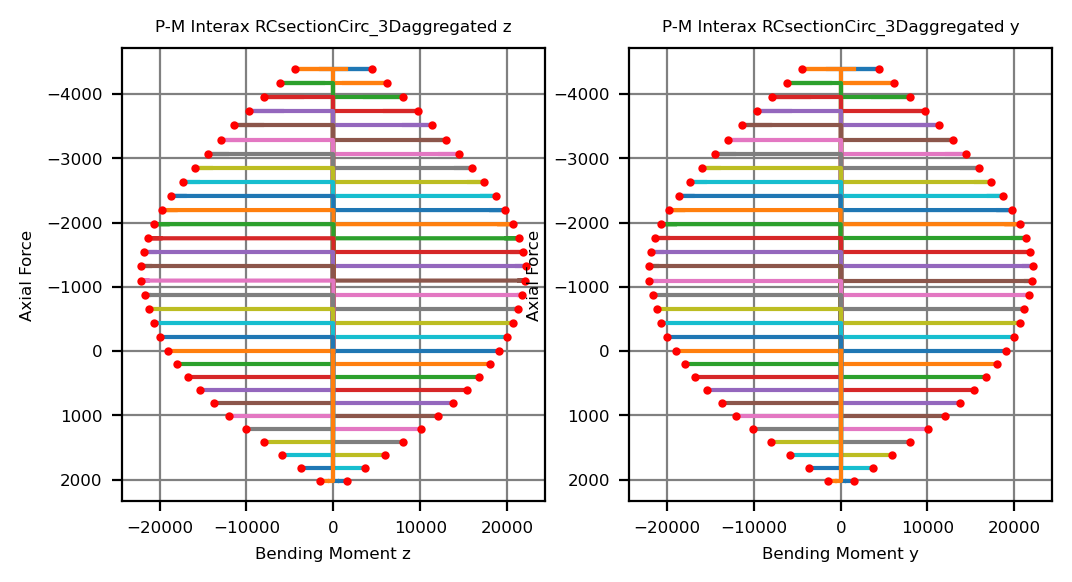

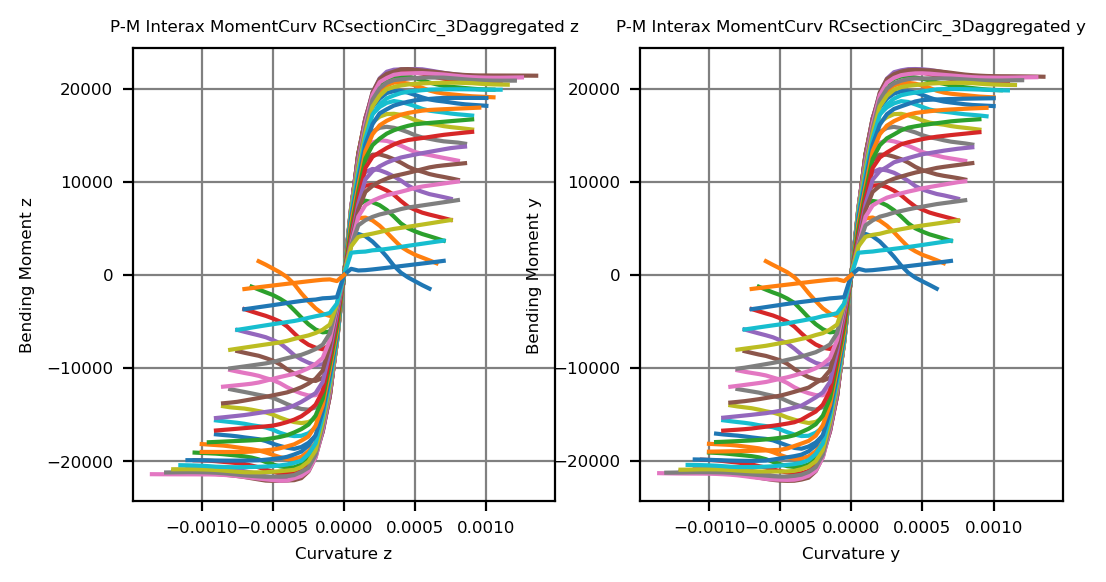

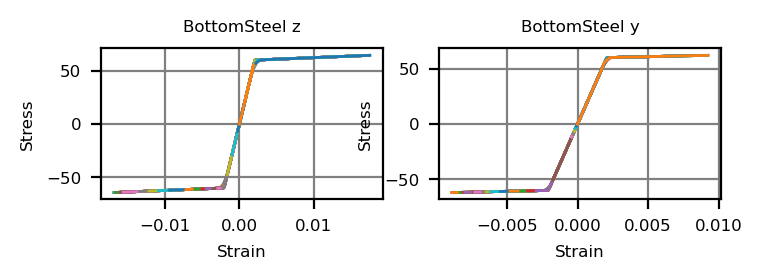

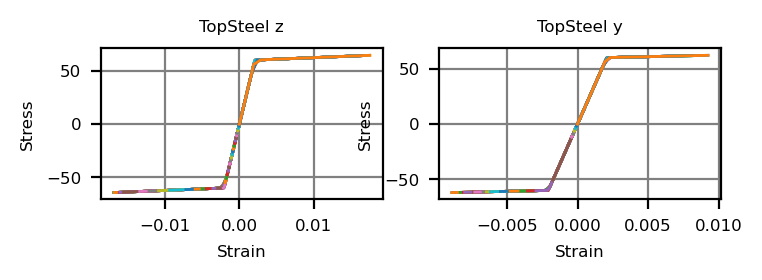

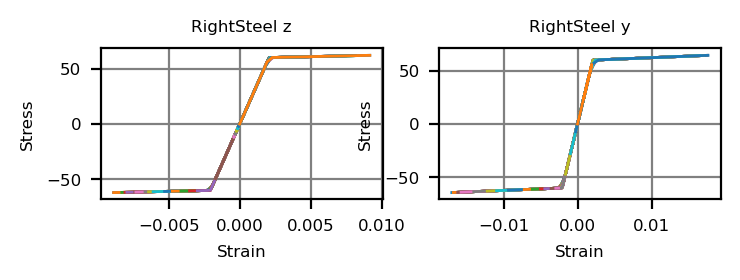

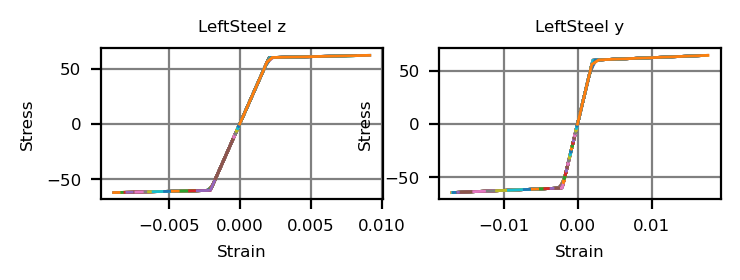

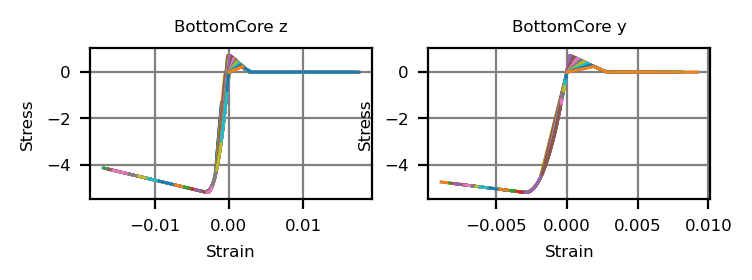

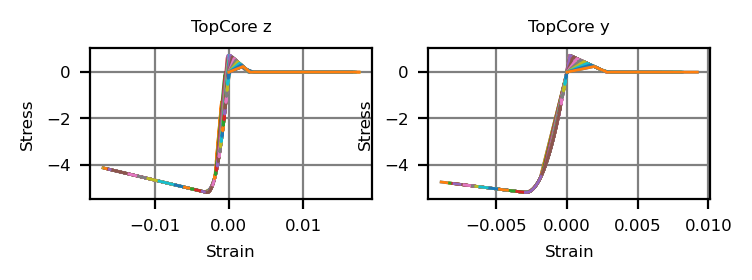

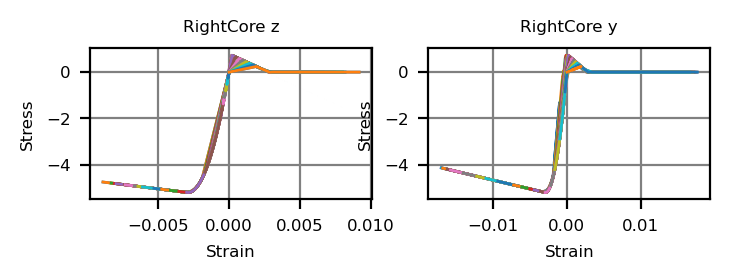

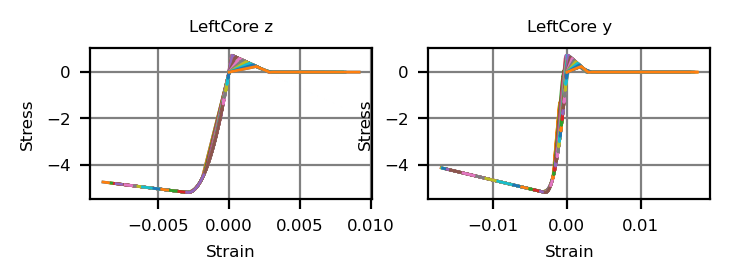

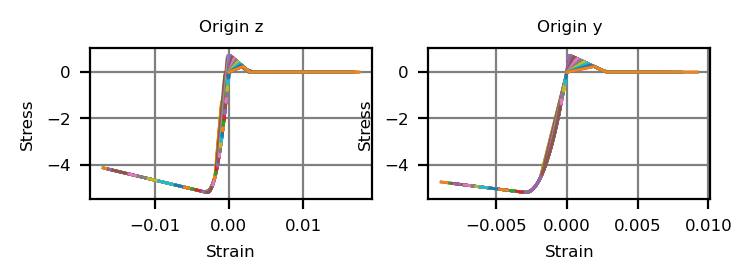

In [23]:
# Plot P-M Interaction Data
plotPMInterax(testSectionLabel,PMinteraxData)

In [24]:
## This Code has been developed by Silvia Mazzoni. Please acknowledge this in your scripts, when applicable